# Большое практическое задание 2

# Применение линейных моделей для определения токсичности комментария

## курс "Машинное обучение 1", программа OzonMasters, 2021

## Студент: Солоднёва Екатерина Алексеевна

## Формулировка задания
Данное задание направлено на ознакомление с линейными моделями и градиентными методами обучения. В
задании необходимо: <br>
1. Написать на языке Python собственную реализацию линейного классификатора с произвольной функцией потерь и реализацию функции и градиента функции потерь для логистической регрессии. Реализации можно частично проверить через юнит-тесты и с помощью системы ejudge в соответствующем соревновании. <br><br> **Внимание.** Прохождение всех тестов в соревновании не гарантирует правильность решения. 


2. Вывести все необходимые формулы, привести выкладки в отчёте. 


3. Провести описанные ниже эксперименты с модельными данными и приложенным датасетом в данном ноутбуке. Подготовить отчёт о проделанной работе. Удалите черновые выводы, оставьте только тот код, который является ответом к пунктам задания. Сохраните ноутбук в форматах .ipynb и .html одновременно. <br><br> **Замечание.** Чтобы экспорировать jupyter notebook в .html нужно выбрать: `File -> Download as -> HTML (.html)`. Для экспорта notebook в .html в Google Colab, воспользуйтесь [следующим кодом](https://gist.github.com/vbugaevskii/b9c6181f2ad83e11f5b9c92d315cb2de). Большая просьба: подписывайте свой отчет (в названии файла и внутри ноутбука).


4. В систему проверки необходимо сдать отчёт в обоих форматах и .zip архив с написанными модулями. <br><br> Большая просьба: jupyter notebook и html файл не запаковывать в архив, а сдавать отдельно.


### Некоторые полезные советы
1. Для того, чтобы не перезагружать jupyter notebook каждый раз после того, как вы внесли изменения в модуль knn, можно добавить ячейку с таким содержимым:
```python
%load_ext autoreload
%autoreload 2
```


2. Не нужно копировать свой код из модулей в jupyter notebook, пользуйтесь им, как если бы это была библиотека. Для этого поместите директорию `modules` рядом с notebook-ом. Пример, как может выглядеть содержимое вашей рабочей директории:
```text
tree
    ---modules
    ------__init__.py
    ------linear_model.py
    ------losses.py
    ------utils.py
    ------tests.py
    ------tests_bouns.py
    HW2_*.ipynb
```

## Теоретическая часть (1 балл)
Выведите формулу градиента функции потерь (по параметру $w$) для задачи бинарной логистической регрессии.

$$L(a(x), y) = \log(1 + \exp(-y\langle w, x\rangle)), \quad y \in \{-1, 1\}$$

Запишите вывод градиента ниже.

Место для ~~вашей рекламы~~ ответа


$$L(a(x), y)_w' = \frac{1}{1 + \exp(-y\langle w, x\rangle)}\exp(-y\langle w, x\rangle)(-y)x=\frac{-yx}{1 + \exp(y\langle w, x\rangle)}$$
~~© Солоднёва Екатерина~~

## Реализация алгоритмов (9 баллов)
Прототипы функций должны строго соответствовать прототипам, описанным в спецификации и проходить все
тесты. Задание, не проходящее все тесты, приравнивается к невыполненному. 


При написании необходимо пользоваться стандартными средствами языка Python, библиотеками `numpy, scipy и matplotlib`. Библиотекой `scikit-learn` для реализаций пользоваться запрещается, но разрешается использовать её в процессе экспериментов. Все
подробности реализации алгоритмов подробно описаны в [спецификации](https://drive.google.com/file/d/1cby1SXsS0TkeFd-3AkE2j1JhKYU9Er1N/view) к заданию.


Ожидается, что реализациия всех классов и функций будет максимально эффективной. Дополнительно вам предоставлены открытые тесты, которые находятся в модуле `modules`. Чтобы запустить тесты в консоли требуется выполнить команду:
```c
$ pytest ./modules/tests.py

```

Разрешается дополнять файл тестами для самопроверки. Доп баллы за написание своих тестов не будет :)


## Предобработка данных (2 балла)
Импортируйте все, что вам потребуется для экспериментов:

In [191]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
plt.rcParams["figure.figsize"] = (20,20)
from tabulate import tabulate

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm
from modules.linear_model import LinearModel
from modules.losses import BinaryLogisticLoss, MultinomialLoss
from modules.utils import get_numeric_grad, compute_balanced_accuracy
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import nltk
stop_list = nltk.corpus.stopwords.words('english')
#stop_list = stopwords.words('english')

nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Екатерина\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Екатерина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 1. Загрузка даннных
Эксперименты этого задания необходимо проводить на датасете, содержащим комментарии из раздела обсуждений английской Википедии, который был преобразован для решения задачи бинарной классификации: является ли данный комментарий токсичным или нет. Подробнее об исходных данных [здесь](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Требуемый для выполнения данного задания датасет можно найти по следующей [ссылке](https://drive.google.com/file/d/1FLTAFR29Koi4YDkLUdVQWNabnBQCTFbn/view). 


Данные в датасете записаны в формате `csv`. Для базовой части экспериментов используйте в качестве целевой переменной столбец `is_toxic`. Обратите внимание на метки классов в датасете, замените их на те, которые ожидает увидеть на вход ваша реализация `LinearModel`.

In [128]:
data = pd.read_csv('train.csv')
data.head()

,comment_text,is_toxic,toxic_level,insult,obscene,obscene_and_insult,no_obscene_no_insult
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### 2. Предобработка текста
Произведите предварительную обработку текста. Приведите все тексты к нижнему регистру. Замените в тексте все символы, не являющиеся буквами и цифрами, на пробелы. Примените алгоритм лемматизации (например, `WordNetLemmatizer` из библотеки `nltk`) к коллекции. Удалите из текста стоп-слова (например, используя список стоп-слов из `nltk`).

**Замечание.** Полезные функции: `str.lower, str.split, str.isalnum, re.sub, re.split`.

In [43]:
data = data.replace('\n',' ', regex=True)
data = data.replace('[^a-zA-Z0-9]', ' ', regex=True)
data = data.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

In [130]:
data['comment_text'] = data['comment_text'].str.lower()

In [131]:
data.head()

,comment_text,is_toxic,toxic_level,insult,obscene,obscene_and_insult,no_obscene_no_insult
0,explanation why the edits made under my userna...,0,0,0,0,0,0
1,d aww he matches this background colour i m s...,0,0,0,0,0,0
2,hey man i m really not trying to edit war it...,0,0,0,0,0,0
3,more i can t make any real suggestions on im...,0,0,0,0,0,0
4,you sir are my hero any chance you remember...,0,0,0,0,0,0


In [135]:
data.isnull().sum()

comment_text            0
is_toxic                0
toxic_level             0
insult                  0
obscene                 0
obscene_and_insult      0
no_obscene_no_insult    0
dtype: int64

In [136]:
lemmatizer = WordNetLemmatizer()

def lemmat(comment):
    word_list = word_tokenize(comment)
    filtered_sentence = [lemmatizer.lemmatize(w) for w in word_list if not w.lower() in stop_list]
    filtered_sentence = []
    for w in word_list:
        if w not in stop_list:
            filtered_sentence.append(w)
    return filtered_sentence

In [134]:
for i in tqdm(range(len(data))):
    data['comment_text'][i] = lemmat(data["comment_text"][i])

  0%|                                                                                       | 0/159571 [00:00<?, ?it/s]c:\users\екатерина\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|█████████████████████████████████████████████████████████████████████████| 159571/159571 [13:31<00:00, 196.62it/s]


In [138]:
data.to_csv('train_sample.csv')

In [216]:
data = pd.read_csv('train_sample.csv')
data.head()

,Unnamed: 0,comment_text,is_toxic,toxic_level,insult,obscene,obscene_and_insult,no_obscene_no_insult
0,0,"['explanation', 'edits', 'made', 'username', '...",0,0,0,0,0,0
1,1,"['aww', 'matches', 'background', 'colour', 'se...",0,0,0,0,0,0
2,2,"['hey', 'man', 'really', 'trying', 'edit', 'wa...",0,0,0,0,0,0
3,3,"['make', 'real', 'suggestions', 'improvement',...",0,0,0,0,0,0
4,4,"['sir', 'hero', 'chance', 'remember', 'page']",0,0,0,0,0,0


### 3. Train/val
Разделите данные на обучение и валидацию. Для валидации выберете $30\%$ случайных объектов из датасета. Рекомендуется использовать функцию `sklearn.model_selection.train_test_split`.

In [217]:
X = data["comment_text"]
y = data['is_toxic'].replace(0,-1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)
X_train.apply(lambda x: ''.join(x))

72397     ['honors', 'section', 'made', 'minor', 'edits'...
144228    ['believe', 'discussion', 'curiosity', 'part',...
139432    ['contested', 'deletion', 'article', 'speedily...
72634     ['gears', 'friends', 'still', 'sent', 'adherei...
121222    ['every', 'source', 'including', 'original', '...
                                ...                        
105560    ['commercials', 'erin', 'esurance', 'totally',...
52113                  ['oppose', 'nomination', 'withdraw']
105651    ['appreciate', 'leaving', 'welcome', 'message'...
21855     ['sure', 'sony', 'youth', 'great', 'irish', 'f...
69250     ['silly', 'simply', 'foreign', 'translations',...
Name: comment_text, Length: 111699, dtype: object

### 4. Tf-idf
Преобразуйте текст в разреженную матрицу `scipy.sparse.csr_matrix`, где значение $x$ в позиции $(i, j)$ сответствует tf-idf характеристке $j$-го слова в $i$-ом документе. Рекомендуется использовать конструктор `sklearn.feature_extraction.text.TfidfVectorizer`. Добавьте в данные единичный столбец на **нулевой** позиции.

**Замечание 1.** У `TfidfVectorizer` есть несколько методов для работы, используйте `fit_transform` и `fit` для обучающей выборки, используйте `transform` для тестовой.


**Замечание 2.** Используйте параметр `min_df`, чтобы уменьшить размерность данных и ускорить проведение экспериментов. Рекомендуется использовать `min_df` не меньше $5$.


**Замечание 3.** Для добавления единичного столбца, можно воспользоваться следующей инструкцией:
```python
from scipy.sparse import hstack, csr_matrix
X = csr_matrix(hstack([csr_matrix(np.ones((X.shape[0], 1))), X]))
```

In [218]:
vectorizer = TfidfVectorizer(min_df=20)

X_train = vectorizer.fit_transform(X_train.apply(lambda x: ''.join(x)))
X_val = vectorizer.transform(X_val.apply(lambda x: ''.join(x)))

In [219]:
X_val = csr_matrix(hstack([csr_matrix(np.ones((X_val.shape[0], 1))), X_val]))
X_train = csr_matrix(hstack([csr_matrix(np.ones((X_train.shape[0], 1))), X_train]))

In [215]:
%reload_ext autoreload

#### Ответьте на следующие вопросы

1. Поясните, почему мы хотим хранить данные в разреженных матрицах CSR формата? Почему для данной задачи этот формат подходит лучше DOK формата (словарь, где ключ это пара (строка, столбец), а значение это соответствующий строке и столбцу элемент матрицы)?

    Потому что CSR формат куда лучше подходит для разреженных матриц, а это как раз наш случай. Ведь слов в данных много больше слов в одной строке.

## Эксперименты (13 баллов)

### 1. Исследование параметров градиентного спуска (3 балла)

В спецификации предлагается использовать следующую формулу для выбора темпа обучения $\eta_k$:


$$\eta_k  = \frac{\alpha}{k^{\beta}}, \quad \text{где $\alpha$, $\beta$ - заданные константы}, \; \text{$k$ - номер итерации}$$


Исследуйте поведение градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

- параметр темпа обучения `step_alpha`
- параметр темпа обучения `step_beta`

Исследование поведения подразумевает анализ следующих зависимостей на обучающей и валидационной
выборках:

- зависимость значения функции потерь от реального времени работы метода
- зависимость значения функции потерь от эпохи метода
- значение метрики качества после обучения метода

В качестве метрики качества здесь и далее предлагается использовать сбалансированную точность (balanced accuracy), реализацию, совместимую с множеством меток $\{−1, 1\}$, можно найти в модуле `utils`.


**Замечание.** Для оценки времени долго работающих функций можно пользоваться либо функциями из модуля `time`, либо magic-командой `%time`, которая запускает код лишь один раз.


In [182]:
alpha_list = [0.5, 1, 2]
beta_list = [0.5, 1, 2]

full_dict = {i: [] for i in ['Q_loss_train','Q_loss_val',  
                             'acc_train','acc_val',
                             'full_time','alpha/beta']}

for alpha in alpha_list:
    for beta in beta_list:
        clf = LinearModel(loss_function=BinaryLogisticLoss(l2_coef=0.1), step_alpha=alpha, step_beta=beta)
        history = clf.fit(X_train, y_train, trace=True, X_val=X_val, y_val=y_val)
        threshold = clf.get_optimal_threshold(X_val, y_val)
        y_pred_train = clf.predict(X_train, threshold = threshold)
        y_pred_val = clf.predict(X_val, threshold = threshold)

        full_dict['alpha/beta'].append((alpha, beta))
        full_dict['Q_loss_train'].append(history['func'])
        full_dict['Q_loss_val'].append(history['func_val'])
        full_dict['full_time'].append(np.sum(history['time']))
        full_dict['acc_train'].append(compute_balanced_accuracy(y_train, y_pred_train))
        full_dict['acc_val'].append(compute_balanced_accuracy(y_val, y_pred_val))
        


#### Приведите график / таблицу с результатами ваших экспериментов

Зависимость функции лосса от времени

In [203]:
mydata = [[full_dict['alpha/beta'][i],full_dict['full_time'][i], 
           min(full_dict['Q_loss_train'][i]),min(full_dict['Q_loss_val'][i])] for i in range(9)]

# create header
head = ["alpha/beta","time", "loss_train", "loss_val"]
  
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))



+--------------+----------+--------------+------------+
| alpha/beta   |     time |   loss_train |   loss_val |
+==============+==========+==============+============+
| (0.5, 0.5)   | 27.2652  |     0.330249 |   0.32975  |
+--------------+----------+--------------+------------+
| (0.5, 1)     | 27.6556  |    86.4392   |  86.4376   |
+--------------+----------+--------------+------------+
| (0.5, 2)     | 18.5318  |   284.798    | 284.794    |
+--------------+----------+--------------+------------+
| (1, 0.5)     | 25.9402  |     0.328677 |   0.328183 |
+--------------+----------+--------------+------------+
| (1, 1)       | 27.7137  |    18.604    |  18.603    |
+--------------+----------+--------------+------------+
| (1, 2)       |  8.61061 |   196.95     | 196.948    |
+--------------+----------+--------------+------------+
| (2, 0.5)     |  3.42133 |     0.328676 |   0.328183 |
+--------------+----------+--------------+------------+
| (2, 1)       |  9.16517 |     1.02683  |   1.0

Зависимость функции лосса от эпохи
(Видимо, у меня индусские корни)

Text(0.5, 1.0, 'alpha=2, beta= 0.5/1/2')

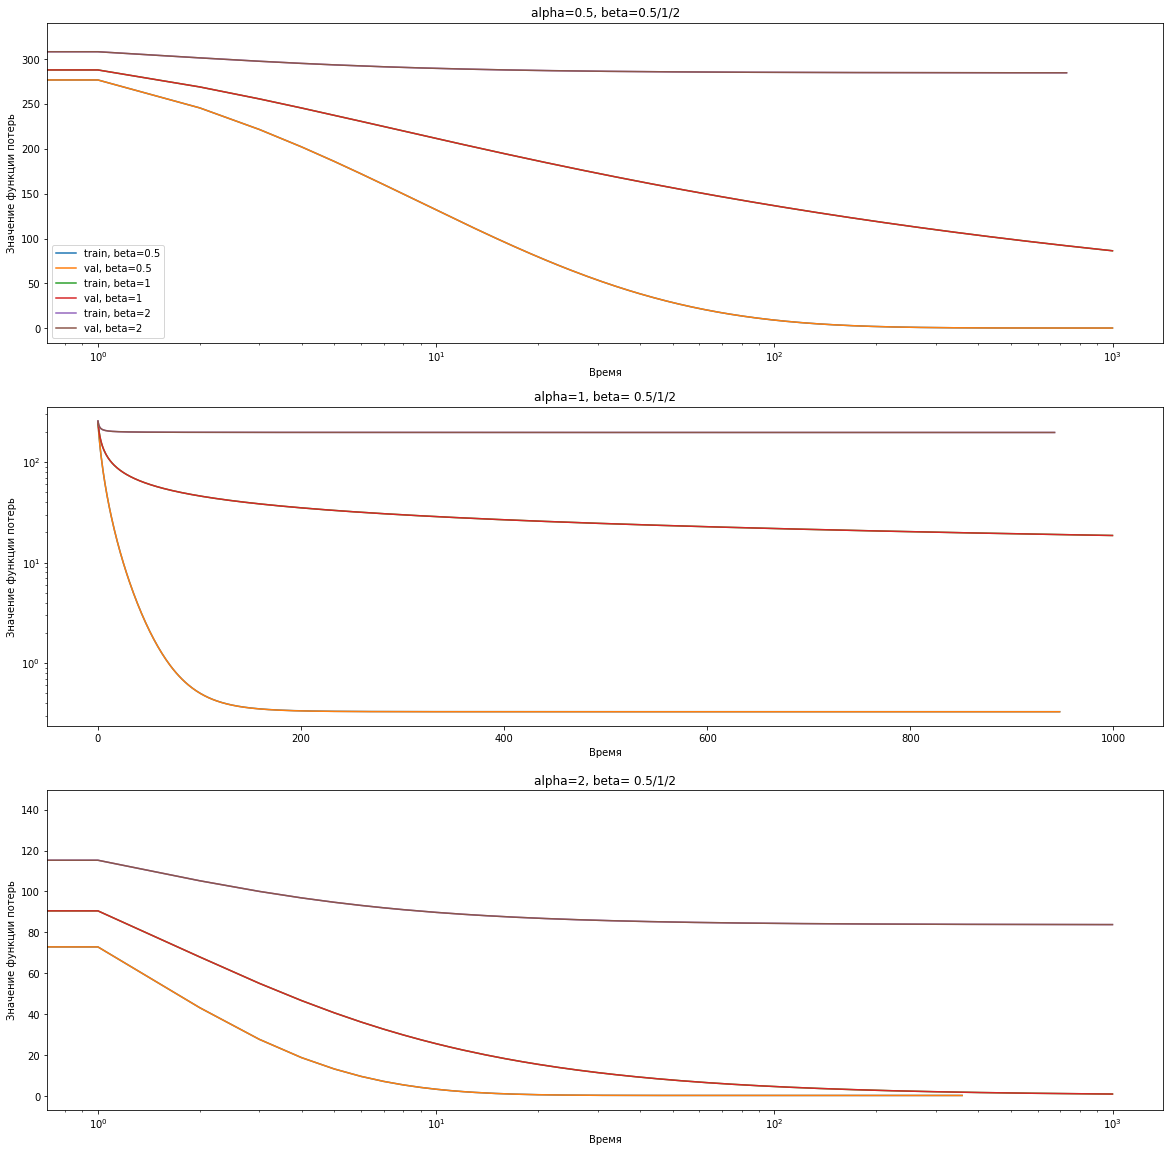

In [242]:
fig, axs = plt.subplots(3)
x_list = np.arange(len(full_dict['Q_loss_train'][0]))
axs[0].plot(x_list, full_dict['Q_loss_train'][0])
axs[0].plot(x_list, full_dict['Q_loss_val'][0])
x_list = np.arange(len(full_dict['Q_loss_train'][1]))
axs[0].plot(x_list, full_dict['Q_loss_train'][1])
axs[0].plot(x_list, full_dict['Q_loss_val'][1])
x_list = np.arange(len(full_dict['Q_loss_train'][2]))
axs[0].plot(x_list, full_dict['Q_loss_train'][2])
axs[0].plot(x_list, full_dict['Q_loss_val'][2])
axs[0].set_xscale('log')
axs[0].set_xlabel("Время")
axs[0].set_ylabel("Значение функции потерь")
axs[0].set_title('alpha=0.5, beta=0.5/1/2')
axs[0].legend(['train, beta=0.5', 'val, beta=0.5', 'train, beta=1', 'val, beta=1', 'train, beta=2', 'val, beta=2'])

x_list = np.arange(len(full_dict['Q_loss_train'][3]))
axs[1].plot(x_list, full_dict['Q_loss_train'][3])
axs[1].plot(x_list, full_dict['Q_loss_val'][3])
x_list = np.arange(len(full_dict['Q_loss_train'][4]))
axs[1].plot(x_list, full_dict['Q_loss_train'][4])
axs[1].plot(x_list, full_dict['Q_loss_val'][4])
x_list = np.arange(len(full_dict['Q_loss_train'][5]))
axs[1].plot(x_list, full_dict['Q_loss_train'][5])
axs[1].plot(x_list, full_dict['Q_loss_val'][5])
axs[1].set_yscale('log')
axs[1].set_xlabel("Время")
axs[1].set_ylabel("Значение функции потерь")
axs[1].set_title('alpha=1, beta= 0.5/1/2')

x_list = np.arange(len(full_dict['Q_loss_train'][6]))
axs[2].plot(x_list, full_dict['Q_loss_train'][6])
axs[2].plot(x_list, full_dict['Q_loss_val'][6])
x_list = np.arange(len(full_dict['Q_loss_train'][7]))
axs[2].plot(x_list, full_dict['Q_loss_train'][7])
axs[2].plot(x_list, full_dict['Q_loss_val'][7])
x_list = np.arange(len(full_dict['Q_loss_train'][8]))
axs[2].plot(x_list, full_dict['Q_loss_train'][8])
axs[2].plot(x_list, full_dict['Q_loss_val'][8])
axs[2].set_xscale('log')
axs[2].set_xlabel("Время")
axs[2].set_ylabel("Значение функции потерь")
axs[2].set_title('alpha=2, beta= 0.5/1/2')

Зависимость метрики качества

In [202]:


mydata = [[full_dict['alpha/beta'][i],full_dict['acc_train'][i],full_dict['acc_val'][i]] for i in range(9)]
# create header
head = ["alpha/beta", "acc_train", "acc_val"]
  
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))


+--------------+-------------+-----------+
| alpha/beta   |   acc_train |   acc_val |
+==============+=============+===========+
| (0.5, 0.5)   |    0.755023 |  0.756603 |
+--------------+-------------+-----------+
| (0.5, 1)     |    0.500045 |  0.50007  |
+--------------+-------------+-----------+
| (0.5, 2)     |    0.500046 |  0.500214 |
+--------------+-------------+-----------+
| (1, 0.5)     |    0.861955 |  0.860825 |
+--------------+-------------+-----------+
| (1, 1)       |    0.499949 |  0.500109 |
+--------------+-------------+-----------+
| (1, 2)       |    0.500061 |  0.500065 |
+--------------+-------------+-----------+
| (2, 0.5)     |    0.86123  |  0.860205 |
+--------------+-------------+-----------+
| (2, 1)       |    0.499619 |  0.500275 |
+--------------+-------------+-----------+
| (2, 2)       |    0.498397 |  0.500131 |
+--------------+-------------+-----------+


[[(0.5, 0.5), 0.7550227699229405, 0.7566027989509292],
 [(0.5, 1), 0.5000448502003308, 0.5000697479773086],
 [(0.5, 2), 0.5000455561574364, 0.5002139033647036],
 [(1, 0.5), 0.8619549775461355, 0.8608246086172143],
 [(1, 1), 0.49994916144178747, 0.5001092813987407],
 [(1, 2), 0.5000605062242134, 0.5000645240547283],
 [(2, 0.5), 0.8612300990363106, 0.8602054876828324],
 [(2, 1), 0.4996194044929969, 0.5002749448043784],
 [(2, 2), 0.4983974528155591, 0.5001313060686672]]

#### Ответьте на следующие вопросы

1. По результатам экспериментов, какие параметры `step_alpha` и `step_beta` вы считаете наиболее оптимальными? Если пар оптимальных параметров получилось несколько, какую пару вы выберете для дальнейших экпериментов и почему?

    Из первой таблицы видно, что с ростом беты ухудшается лосс, значит оптимальным параметром стоит выбрать минимальную бету (0.5), из последней заметно, что выбирать альфу можно, какую угодно, но не минимальную. Выберу альфу = 2, тк у неё быстрее время работы.

2. Какие зависимости между параметрами `step_alpha`/`step_beta` и временем работы алгоритма/кол-ва эпох вы наблюдаете? Опишите свои наблюдения.
    Занятно, что значения функции регуляризации на валидации и обучении совпадают (почему-то даже на log шкале). По графикам видно, что чем больше альфа и чем меньше бета, тем быстрее алгоритм спускается к нужному значению.
    
    
    
3. Поясните, в чём преимущество использования balanced accuracy для этой задачи по сравнению с обычной accuracy?

    Сбалансированная точность используется для неравного соотношения наборов значений целевых меток, у нас соотношение токсичных комментариев к обычным довольно маленькое, поэтому точность, используемая для соотношения 1 к 1 покажет низкие результаты.

### 2. Исследование параметров стохастического градиентного спуска (3 балла)
Исследуйте поведение стохастического градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

- параметр темпа обучения `step_alpha`
- параметр темпа обучения `step_beta`
- размер подвыборки `batch_size`

**Замечание.** Обратите внимание, что в стохастическом случае необходимо строить зависимости метрик качества от эпохи метода. За одну эпоху через оптимизацию модели проходит $N$ объектов, где $N$ — длина обучающей выборки. Если вы реализуете семплирование согласно спецификации задания, то за одну эпоху каждый объект пройдёт через оптимизацию ровно один раз. В полном градиентном спуске одна эпоха метода соответствует одной итерации обучения.

Для лучшей пары параметров подберём лучший размер батча, а затем на нём снова подберём параметры. (Иначе долго и слишком много информации для обработки).

In [227]:
N = int(len(y))
N

159571

In [229]:
alpha = 2
beta = 0.5

In [244]:
batch_list = [int(N/10), int(N/20), int(N/50), int(N/100)]

full_dict_b = {i: [] for i in ['Q_loss_train','Q_loss_val',  
                             'acc_train','acc_val',
                             'full_time','batch_size']}

for batch in batch_list:
    clf = LinearModel(loss_function=BinaryLogisticLoss(l2_coef=0.1), step_alpha=alpha, step_beta=beta, batch_size=batch)
    history = clf.fit(X_train, y_train, trace=True)
    threshold = clf.get_optimal_threshold(X_val, y_val)
    y_pred_train = clf.predict(X_train, threshold = threshold)
    y_pred_val = clf.predict(X_val, threshold = threshold)

    full_dict_b['batch_size'].append(batch)
    full_dict_b['Q_loss_train'].append(history['func'])
    full_dict_b['Q_loss_val'].append(history['func_val'])
    full_dict_b['full_time'].append(np.sum(history['time']))
    full_dict_b['acc_train'].append(compute_balanced_accuracy(y_train, y_pred_train))
    full_dict_b['acc_val'].append(compute_balanced_accuracy(y_val, y_pred_val))



#### Приведите график / таблицу с результатами ваших экспериментов

In [245]:
mydata = [[full_dict_b['batch_size'][i],full_dict_b['acc_train'][i],full_dict_b['acc_val'][i],full_dict_b['full_time'][i]] for i in range(4)]
# create header
head = ["batch_size", "acc_train", "acc_val", "full_time"]
  
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))


+--------------+-------------+-----------+-------------+
|   batch_size |   acc_train |   acc_val |   full_time |
+==============+=============+===========+=============+
|        15957 |    0.646777 |  0.647574 |    32.1612  |
+--------------+-------------+-----------+-------------+
|         7978 |    0.866729 |  0.857558 |     5.87029 |
+--------------+-------------+-----------+-------------+
|         3191 |    0.863605 |  0.856208 |     2.46583 |
+--------------+-------------+-----------+-------------+
|         1595 |    0.863555 |  0.856096 |     2.7182  |
+--------------+-------------+-----------+-------------+


In [251]:
alpha_list = [0.5, 1, 2]
beta_list = [0.5, 1, 2]
batch_size = int(N/20)
full_dict_b1 = {i: [] for i in ['Q_loss_train','Q_loss_val',  
                             'acc_train','acc_val',
                             'full_time','alpha/beta']}

for alpha in alpha_list:
    for beta in beta_list:
        clf = LinearModel(loss_function=BinaryLogisticLoss(l2_coef=0.1), step_alpha=alpha, step_beta=beta, batch_size=batch_size)
        history = clf.fit(X_train, y_train, trace=True, X_val=X_val, y_val=y_val)
        threshold = clf.get_optimal_threshold(X_val, y_val)
        y_pred_train = clf.predict(X_train, threshold = threshold)
        y_pred_val = clf.predict(X_val, threshold = threshold)
        full_dict_b1['Q_loss_train'].append(history['func'])
        full_dict_b1['Q_loss_val'].append(history['func_val'])
        full_dict_b1['full_time'].append(np.sum(history['time']))
        full_dict_b1['alpha/beta'].append((alpha, beta))
        full_dict_b1['acc_train'].append(compute_balanced_accuracy(y_train, y_pred_train))
        full_dict_b1['acc_val'].append(compute_balanced_accuracy(y_val, y_pred_val))
        


In [252]:
mydata = [[full_dict_b1['alpha/beta'][i],full_dict_b1['full_time'][i],full_dict_b1['acc_val'][i], full_dict_b1['Q_loss_val'][i]] for i in range(9)]
# create header
head = ["alpha/beta","full_time", "acc_train", "acc_val"]
  
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))


+--------------+-------------+-------------+-----------+
| alpha/beta   |   full_time |   acc_train |   acc_val |
+==============+=============+=============+===========+
| (0.5, 0.5)   |    26.4994  |    0.863535 |  0.856196 |
+--------------+-------------+-------------+-----------+
| (0.5, 1)     |    70.4686  |    0.865264 |  0.857908 |
+--------------+-------------+-------------+-----------+
| (0.5, 2)     |    98.6531  |    0.499995 |  0.500166 |
+--------------+-------------+-------------+-----------+
| (1, 0.5)     |   107.236   |    0.863552 |  0.856153 |
+--------------+-------------+-------------+-----------+
| (1, 1)       |     8.71541 |    0.863761 |  0.856237 |
+--------------+-------------+-------------+-----------+
| (1, 2)       |    38.9464  |    0.564939 |  0.572334 |
+--------------+-------------+-------------+-----------+
| (2, 0.5)     |   109.235   |    0.86352  |  0.856185 |
+--------------+-------------+-------------+-----------+
| (2, 1)       |     6.68105 | 

#### Ответьте на следующие вопросы

1. По результатам экспериментов, какие параметры `step_alpha`, `step_beta` и `batch_size` вы считаете наиболее оптимальными? Если троек оптимальных параметров получилось несколько, какую пару вы выберете для дальнейших экпериментов и почему?

    
    Лучшая точность наблюдается при размере батча N/20. Далее подберём гиперпараметры для него. Выберем пару (2, 2) по лучшей точности + времени схождения.
    

2. Какие зависимости между параметрами `step_alpha`/`step_beta`/`batch_size` и временем работы алгоритма/кол-ва эпох вы наблюдаете? Опишите свои наблюдения.

    Время работы  почти всегда уменьшалось вместе с уменьшением батча. При бета = 0.5 алгоритм очень медленно работает, такую бету я бы точно не выбрала. При остальных значениях примерно одинаково, но лучше всего в среднем алгоритм себя показывает при бета = 1. 
    Лучшее время везде - там, где alpha=beta.
    

### 3. Сравнение двух методов (2 балла)
Сравните поведение двух методов между собой, и ответьте на следующие вопросы

1. Какой алгоритм вы выберете для дальнейших экспериментов и почему?

    Стохастический алгоритм, как в теории, так и в этом эксперименте, показал себя лучше. Из-за "гибкости" шага алгоритм стохастического спуска должен быстрее сходиться.
    

2. Есть ли разница между парами оптимальных параметров `step_alpha` и `step_beta` в двух алгоритмах? Объясните разницу/отсутствие разницы в результатах.

    Разница получилась значительная. Во втором случае зависимость куда сложнее проследить, не зря алгоритм прозвали случайным.

### 4. Регуляризация (2 балла)
Подберите по отложенной выборке коэффициент $l2$-регуляризации модели. 

Приведите график с результатами ваших экспериментов. Обоснуйте свой выбор.


In [253]:
l2_list = [0.05, 0.1, 0.5, 1, 2]
alpha = 2
beta = 2
batch_size = int(N/20)
full_dict_l = {i: [] for i in ['Q_loss_train','Q_loss_val',  
                             'acc_train','acc_val',
                             'full_time','l2_coef']}

for l2 in l2_list:
    clf = LinearModel(loss_function=BinaryLogisticLoss(l2_coef=l2), step_alpha=alpha, step_beta=beta, batch_size=batch_size)
    history = clf.fit(X_val, y_val)
    threshold = clf.get_optimal_threshold(X_val, y_val)
    y_pred_val = clf.predict(X_val, threshold = threshold)

    full_dict_l['l2_coef'].append(l2)
    full_dict_l['acc_val'].append(compute_balanced_accuracy(y_val, y_pred_val))



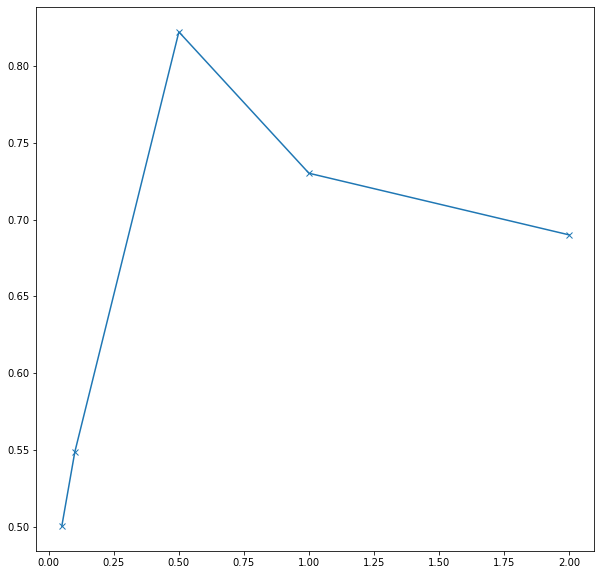

In [255]:
plt.figure(figsize=(10,10))
plt.plot(full_dict_l['l2_coef'], full_dict_l['acc_val'], marker='x')

Точность выше всего для 0.5. Выберу его.

### 5. Измерение качества и интерпретация результатов (3 балла)
Выберите лучший алгоритм для тестовой выборки. Обратите внимание, что необходимо использовать порог бинаризации, выбранный на отложенной выборке.

Загрузим выборку, обработанную аналогично обучающей:

In [278]:
data1 = pd.read_csv('test_sample.csv')
data = pd.read_csv('train_sample.csv')

X_test = data1["comment_text"]
y_test = data1['is_toxic'].replace(0,-1)
X = data["comment_text"]
y = data['is_toxic'].replace(0,-1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

In [279]:
vectorizer = TfidfVectorizer(min_df=20)

X_train = vectorizer.fit_transform(X_train.apply(lambda x: ''.join(x)))
X_test = vectorizer.transform(X_test.apply(lambda x: ''.join(x)))
X_test = csr_matrix(hstack([csr_matrix(np.ones((X_test.shape[0], 1))), X_test]))
X_train = csr_matrix(hstack([csr_matrix(np.ones((X_train.shape[0], 1))), X_train]))

X_val = vectorizer.transform(X_val.apply(lambda x: ''.join(x)))
X_val = csr_matrix(hstack([csr_matrix(np.ones((X_val.shape[0], 1))), X_val]))

In [281]:
l2_coef = 0.5
alpha = 2
beta = 2
batch_size = int(N/20)

clf = LinearModel(loss_function = BinaryLogisticLoss(l2_coef=l2_coef), batch_size = batch_size, step_alpha = alpha, step_beta = beta)
clf.fit(X_train, y_train)
threshold = clf.get_optimal_threshold(X_val, y_val)

y_pred_val = clf.predict(X_val, threshold = threshold)
y_pred_test = clf.predict(X_test, threshold = threshold)

print("val acc:", compute_balanced_accuracy(y_val, y_pred_val), "test acc:", compute_balanced_accuracy(y_test, y_pred_test))

val acc: 0.8477768982230279 test acc: 0.8383732165059941


#### Ответьте на следующие вопросы

1. Примените лучший алгоритм к тестовой выборке и посмотрите на метрику качества. Сравните ее с метрикой на валидации. Опишите ваши наблюдения.

    Неплохо, но можно было лучше.

2. Проанализируйте ошибки алгоритма. Проанализируйте и укажите общие черты объектов, на которых были допущены ошибки. Наблюдения опишите.

    Алгоритм, видимо, выбрал за токсичные слова какие-то очень плохие слова. А вот относительно нормальные слова "мать", "евреи" и "раса" у него отторжения не вызывают.


In [289]:
X_test = data1["comment_text"]
X_test[(y_test != y_pred_test)][0:5], y_test[(y_test != y_pred_test)][0:5]

(1                   ['dear', 'god', 'site', 'horrible']
 9     ['please', 'stop', 'continue', 'vandalize', 'w...
 12    ['jews', 'race', 'get', 'mother', 'mention', '...
 17    ['balance', 'page', 'one', 'sentence', 'basic'...
 27    ['burn', 'hell', 'revoke', 'talk', 'page', 'ac...
 Name: comment_text, dtype: object,
 1    -1
 9    -1
 12   -1
 17   -1
 27   -1
 Name: is_toxic, dtype: int64)

In [ ]:
## your code here ##

3. Проинтерпретируйте линейные коэффициенты признаков. Выберите коэффициенты с набиольшим значением и коэффициенты с наименьшим значением. Проанализируйте, каким словам они соответствуют. Согласуются ли ваши наблюдения с вашими ожиданиями от модели?

    *ваш ответ*

In [ ]:
## your code here ##

## Бонусная часть
В бонусной части предлагается решить более сложную задачу — нужно не просто определить токсичное сообщение или нет, а понять тип токсичности. По сути вам нужно решить задачу классификации на $5$ классов: `insult`, `obscene`, `obscene_and_insult`, `no_obscene_no_insult` и `not_toxic`. Все новые целевые переменные записаны в соответствующих столбцах, `not_toxic` можно получить инвертировав столбец `is_toxic`.

### 1. Теоретическая часть (1 балл)
Выведите формулу градиента функции потерь для задачи мультиномиальной регресии. Запишите вывод градиента в отчёт:
$$p(y|x) = \frac{\exp(\langle w_y, x \rangle)}{\sum_{u \in Y}\exp(\langle w_u, x \rangle)}, \quad Y = \{1, \ldots, K\}$$


$$L(a(x), y) = -\log p(y|x), \quad a(x) = \{\langle w_y, x \rangle\}_{y \in Y}, \quad y \in Y $$

### 2. Мультиномиальная регрессия (до 3 баллов)
Реализуйте функцию потерь для задачи мультиномиальной регрессии. Обучите модель для задачи многоклассовой классификации. Используя разбиение данных на обучение и валидацию, подберите оптимальный коэффициент $l2$-регуляризации. В файле `tests_bonus.py` есть несколько тестов для самопроверки.


**Замечание.** Обратите внимание, что вам не нужно проводить заново предобработку данных.

In [33]:
## your code here ##

### 3. Многоклассовая классификация (до 2 баллов)
Постройте модель многоклассовой классификации используя подход `OneVsAll`. Воспользуйтесь классом `sklearn.multiclass.OneVsRestClassifier`. Сравните качество подхода с подходом из предыдущего пункта и сделайте выводы.

**Замечание.** Обратите внимание, что класс рассчитан на использование с метками ответов из множества $\{0, 1\}$. 

In [34]:
## your code here ##